In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import pandas as pd

In [2]:
from keras.preprocessing import image, sequence
from keras.applications import VGG16
from keras.layers import Dense, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector, Merge
from keras.models import Sequential, Model
from keras.optimizers import Nadam

Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GTX 1060 6GB (0000:01:00.0)


In [3]:
images_dir = os.listdir("./Flickr8k_Dataset/Flicker8k_Dataset/")

images_path = './Flickr8k_Dataset/Flicker8k_Dataset/'
captions_path = './Flickr8k_text/Flickr8k.token.txt'
train_path = './Flickr8k_text/Flickr_8k.trainImages.txt'
val_path = './Flickr8k_text/Flickr_8k.devImages.txt'

captions = open(captions_path, 'r').read().split("\n")
x_train = open(train_path, 'r').read().split("\n")
x_test = open(val_path, 'r').read().split("\n")

In [4]:
tokens = {}

for ix in range(len(captions)):
    temp = captions[ix].split("#")
    if temp[0] in tokens:
        tokens[temp[0]].append(temp[1][2:])
    else:
        tokens[temp[0]] = [temp[1][2:]]

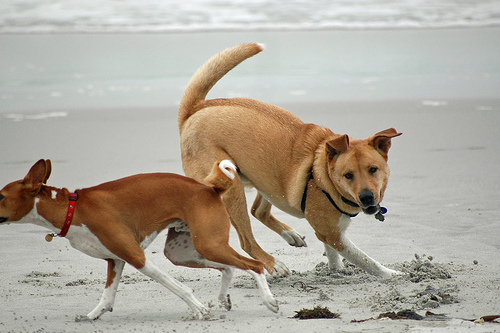

Two different breeds of brown and white dogs play on the beach .
Two dogs are making a turn on a soft sand beach .
Two dogs playing in the sand at the beach .
Two dogs playing together on a beach .
Two large tan dogs play along a sandy beach .


In [5]:
temp = captions[100].split("#")
from IPython.display import Image, display
z = Image(filename=images_path+temp[0])
display(z)

for ix in range(len(tokens[temp[0]])):
    print tokens[temp[0]][ix]

In [6]:
print "Number of Training Images {}".format(len(x_train))

Number of Training Images 6000


In [7]:
vgg = VGG16(weights='imagenet', include_top=True, input_shape=(224,224,3))

In [8]:
def preprocess_input(img):
    img = img[:, :, :, ::-1] #RGB to BGR
    img[:, :, :, 0] -= 103.939 
    img[:, :, :, 1] -= 116.779
    img[:, :, :, 2] -= 123.68
    return img

In [9]:
def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    im = preprocess_input(im)
    return im

In [10]:
vgg = Model(inputs=vgg.input, outputs=vgg.layers[-2].output)

In [11]:
def get_encoding(model, img):
    image = preprocessing(images_path+img)
    pred = model.predict(image)
    pred = np.reshape(pred, pred.shape[1])
    return pred

# Building Vocabulary #

In [12]:
pd_dataset = pd.read_csv("./../Flickr8k_text/flickr_8k_train_dataset.txt", delimiter='\t')
ds = pd_dataset.values
print ds.shape

(30000L, 2L)


In [13]:
sentences = []
for ix in range(ds.shape[0]):
    sentences.append(ds[ix, 1])
    
print len(sentences)

30000


In [14]:
words = [i.split() for i in sentences]

In [15]:
unique = []
for i in words:
    unique.extend(i)

In [16]:
print len(unique)

413377


In [17]:
unique = list(set(unique))
print len(unique)

vocab_size = len(unique)

8253


In [18]:
word_2_indices = {val:index for index, val in enumerate(unique)}
indices_2_word = {index:val for index, val in enumerate(unique)}

In [19]:
print word_2_indices['<start>']
print indices_2_word[4011]

4011
<start>


In [20]:
max_len = 0

for i in sentences:
    i = i.split()
    if len(i) > max_len:
        max_len = len(i)

print max_len

40


# Let's see the Model in action #

In [24]:
captions = np.load("./captions.npy")
next_words = np.load("./next_words.npy")

print captions.shape
print next_words.shape

(19136L, 40L)
(19136L, 8253L)


In [25]:
images = np.load("./images.npy")

print images.shape

(19136L, 4096L)


In [26]:
images = np.load("./image_names.npy")
        
print len(image_names)

19136


In [27]:
embedding_size = 128

In [28]:
image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(4096,), activation='relu'))
image_model.add(RepeatVector(max_len))

image_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               524416    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 40, 128)           0         
Total params: 524,416
Trainable params: 524,416
Non-trainable params: 0
_________________________________________________________________


In [29]:
language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 128)           1056384   
_________________________________________________________________
lstm_1 (LSTM)                (None, 40, 256)           394240    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 40, 128)           32896     
Total params: 1,483,520
Trainable params: 1,483,520
Non-trainable params: 0
_________________________________________________________________


In [31]:
model = Sequential()

model.add(Merge([image_model, language_model], mode='concat', concat_axis=-1))
model.add(LSTM(1000, return_sequences=False))
model.add(Dense(vocab_size))
model.add(Activation('softmax'))

model.load_weights("./model_weights.h5")
model.compile(loss='categorical_crossentropy', optimizer=Nadam(), metrics=['accuracy'])
model.summary()

C:\ProgramData\Anaconda2\envs\ml\lib\site-packages\ipykernel_launcher.py:3: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  This is separate from the ipykernel package so we can avoid doing imports until


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
merge_2 (Merge)              (None, 40, 256)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 2000)              10056000  
_________________________________________________________________
dense_4 (Dense)              (None, 8253)              16514253  
_________________________________________________________________
activation_2 (Activation)    (None, 8253)              0         
Total params: 28,578,189
Trainable params: 28,578,189
Non-trainable params: 0
_________________________________________________________________


In [32]:
# def scheduler(epoch):
#     if epoch%2==0 and epoch!=0:
#         lr = K.get_value(model.optimizer.lr)
#         K.set_value(model.optimizer.lr, lr*.9)
#         print("lr changed to {}".format(lr*.9))
#     return K.get_value(model.optimizer.lr)

# lr_decay = LearningRateScheduler(scheduler)

model.fit([images, captions], next_words, batch_size=512, epochs=50)

Epoch 1/50
19136/19136 [==============================] - 45s - loss: 3.9027 - acc: 0.1983    
Epoch 2/50
19136/19136 [==============================] - 44s - loss: 3.4251 - acc: 0.2300    
Epoch 3/50
19136/19136 [==============================] - 44s - loss: 3.2151 - acc: 0.2468    
Epoch 4/50
19136/19136 [==============================] - 44s - loss: 3.0636 - acc: 0.2597    
Epoch 5/50
19136/19136 [==============================] - 44s - loss: 2.9004 - acc: 0.2767    
Epoch 6/50
19136/19136 [==============================] - 44s - loss: 2.7691 - acc: 0.2907    
Epoch 7/50
19136/19136 [==============================] - 44s - loss: 2.6922 - acc: 0.2976    
Epoch 8/50
19136/19136 [==============================] - 44s - loss: 2.6320 - acc: 0.2983    
Epoch 9/50
19136/19136 [==============================] - 44s - loss: 2.6043 - acc: 0.3010    
Epoch 10/50
19136/19136 [==============================] - 44s - loss: 2.5191 - acc: 0.3119    
Epoch 11/50
19136/19136 [========================

In [31]:
model.save_weights("./model_weights.h5")

# Prediction on test images #

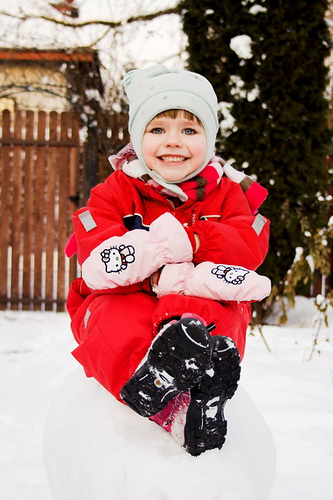

In [32]:
img = "3320032226_63390d74a6.jpg"

test_img = get_encoding(vgg, img)

z = Image(filename=images_path+img)
display(z)

In [34]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word_2_indices[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        preds = model.predict([np.array([image]), np.array(par_caps)])
        word_pred = indices_2_word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

Argmax_Search = predict_captions(test_img)

In [35]:
def beam_search_predictions(image, beam_index = 3):
    start = [word_2_indices["<start>"]]
    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_len:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_len, padding='post')
            preds = model.predict([np.array([image]), np.array(par_caps)])
            
            word_preds = np.argsort(preds[0])[-beam_index:] #Top n prediction
            
            for w in word_preds: #new list so as to feed it to model again
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        start_word = start_word[-beam_index:] # Top n words
    
    start_word = start_word[-1][0]
    intermediate_caption = [indices_2_word[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption


Beam_Search_index_3 = beam_search_predictions(test_img, beam_index=3)
Beam_Search_index_5 = beam_search_predictions(test_img, beam_index=5)
Beam_Search_index_7 = beam_search_predictions(test_img, beam_index=7)

In [36]:
print "Agrmax Prediction : ",
print Argmax_Search
print "Beam Search Prediction with Index = 3 : ",
print Beam_Search_index_3
print "Beam Search Prediction with Index = 5 : ",
print Beam_Search_index_5
print "Beam Search Prediction with Index = 7 : ",
print Beam_Search_index_7

Agrmax Prediction :  A little girl in a a red coat plays in snow .
Beam Search Prediction with Index = 3 :  A little girl plays in the snow in a brown jacket and red shorts on a harness .
Beam Search Prediction with Index = 5 :  Little girl in red coat going down a hill .
Beam Search Prediction with Index = 7 :  Little girl in red coat going down a hill .


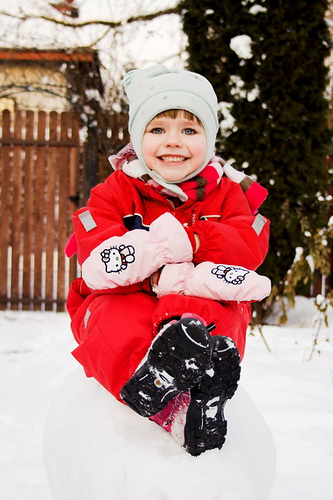

In [37]:
display(z)